In [1]:
import numpy as np
from scipy.io import loadmat

# Load audiovisual features (CAV-MAE)
cavmae_data = loadmat("cavmae_av_embeddings.mat")
X_av = cavmae_data["audiovisual_embeddings"]
print("CAV-MAE features shape:", X_av.shape)


CAV-MAE features shape: (3655, 768)


In [2]:
# Load BEATs audio features and CLIP visual features
beats_data = loadmat("features_per_sec.mat")
X_audio = beats_data["features_per_sec"]
clip_data = loadmat("vision_clip_features.mat")
X_visual = clip_data["features"]
print("BEATs audio features shape:", X_audio.shape)
print("CLIP visual features shape:", X_visual.shape)


BEATs audio features shape: (3655, 768)
CLIP visual features shape: (3655, 768)


In [3]:
# Concatenate audio and visual features
X_av_concat = np.concatenate([X_audio, X_visual], axis=1)
print("Combined BEATs+CLIP features shape:", X_av_concat.shape)

# Load fMRI data for left and right hemispheres
lh_data = loadmat("notmean_left_Meanfile.mat")
rh_data = loadmat("notmean_right_Meanfile.mat")
Y_left = lh_data["Left_data"]
Y_right = rh_data["Right_data"]
# Combine full brain (voxels x time_points) and transpose
Y_full = np.concatenate([Y_left, Y_right], axis=0).T
print("Brain data (full cortex) shape:", Y_full.shape)


Combined BEATs+CLIP features shape: (3655, 1536)
Brain data (full cortex) shape: (3655, 64984)


In [4]:
# Normalize features and fMRI data (z-score normalization)
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normed = (data - mean) / (std + 1e-8)
    return normed

X_av = normalize_data(X_av)
X_av_concat = normalize_data(X_av_concat)
Y_full = normalize_data(Y_full)

In [5]:
window_length = 10

def create_windowed_data(X, Y, window_length):
    n_time = X.shape[0]
    X_windows = []
    Y_targets = []
    for t in range(n_time - window_length + 1):
        window = X[t : t + window_length, :]
        X_windows.append(window.flatten())
        Y_targets.append(Y[t + window_length - 1, :])
    X_windows = np.array(X_windows)
    Y_targets = np.array(Y_targets)
    return X_windows, Y_targets

In [6]:
# Create windowed datasets for both feature sets
X_win_av, Y_win = create_windowed_data(X_av, Y_full, window_length)
X_win_av2, Y_win2 = create_windowed_data(X_av_concat, Y_full, window_length)
print("Windowed feature shape (Model1):", X_win_av.shape)
print("Windowed feature shape (Model2):", X_win_av2.shape)
print("Windowed target (brain) shape:", Y_win.shape)

Windowed feature shape (Model1): (3646, 7680)
Windowed feature shape (Model2): (3646, 15360)
Windowed target (brain) shape: (3646, 64984)


In [7]:
from sklearn.linear_model import Ridge

# Split into train/test (80/20 split without shuffling)
n_samples = X_win_av.shape[0]
split_idx = int(0.8 * n_samples)
X_train1, X_test1 = X_win_av[:split_idx], X_win_av[split_idx:]
Y_train, Y_test = Y_win[:split_idx], Y_win[split_idx:]
X_train2, X_test2 = X_win_av2[:split_idx], X_win_av2[split_idx:]

print("Train set size:", X_train1.shape[0], "samples")
print("Test set size:", X_test1.shape[0], "samples")

Train set size: 2916 samples
Test set size: 730 samples


In [8]:
from sklearn.linear_model import LinearRegression, Ridge

print("Model 1: CAV-MAE Features")

# Linear Regression
linear1 = LinearRegression()
linear1.fit(X_train1, Y_train)
Y_pred1_linear = linear1.predict(X_test1)
print("Linear Regression (Model 1) prediction shape:", Y_pred1_linear.shape)

# Ridge Regression
ridge1 = Ridge(alpha=1.0)
ridge1.fit(X_train1, Y_train)
Y_pred1_ridge = ridge1.predict(X_test1)
print("Ridge Regression (Model 1) prediction shape:", Y_pred1_ridge.shape)

Model 1: CAV-MAE Features
Linear Regression (Model 1) prediction shape: (730, 64984)


/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=4.21794e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge Regression (Model 1) prediction shape: (730, 64984)


In [9]:
print("Model 2: BEATs + CLIP Features")

# Linear Regression
linear2 = LinearRegression()
linear2.fit(X_train2, Y_train)
Y_pred2_linear = linear2.predict(X_test2)
print("Linear Regression (Model 2) prediction shape:", Y_pred2_linear.shape)

# Ridge Regression
ridge2 = Ridge(alpha=1.0)
ridge2.fit(X_train2, Y_train)
Y_pred2_ridge = ridge2.predict(X_test2)
print("Ridge Regression (Model 2) prediction shape:", Y_pred2_ridge.shape)

Model 2: BEATs + CLIP Features
Linear Regression (Model 2) prediction shape: (730, 64984)


/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=2.80597e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge Regression (Model 2) prediction shape: (730, 64984)


In [10]:
from scipy.stats import pearsonr
import scipy.io as sio

# Compute voxel-wise Pearson correlation for each model
def compute_voxel_correlations(Y_true, Y_pred):
    n_vox = Y_true.shape[1]
    r_vals = np.full(n_vox, np.nan)
    for i in range(n_vox):
        y_true = Y_true[:, i]
        y_pred = Y_pred[:, i]
        # Skip if variance is zero (constant signal)
        if np.std(y_true) < 1e-8 or np.std(y_pred) < 1e-8:
            continue
        r_vals[i], _ = pearsonr(y_true, y_pred)
    return r_vals

r_values_cavmae = compute_voxel_correlations(Y_test, Y_pred1_linear)
r_values_beats_clip = compute_voxel_correlations(Y_test, Y_pred2_linear)

# # Save correlation values to MATLAB .mat files
# sio.savemat("ridge_cavmae_r_values.mat", {"r_values": r_values_cavmae})
# sio.savemat("ridge_beats_clip_r_values.mat", {"r_values": r_values_beats_clip})


# Print summary
valid_idx_cavmae = ~np.isnan(r_values_cavmae)
mean_r_cavmae = np.nanmean(r_values_cavmae)
print(f"Model 1 (CAV-MAE, Linear) mean r: {mean_r_cavmae:.3f}")
print(f"Model 1 valid voxels: {valid_idx_cavmae.sum()} / {len(r_values_cavmae)}")

valid_idx_beats_clip = ~np.isnan(r_values_beats_clip)
mean_r_beats_clip = np.nanmean(r_values_beats_clip)
print(f"Model 2 (BEATs+CLIP, Linear) mean r: {mean_r_beats_clip:.3f}")
print(f"Model 2 valid voxels: {valid_idx_beats_clip.sum()} / {len(r_values_beats_clip)}")


Model 1 (CAV-MAE, Linear) mean r: 0.258
Model 1 valid voxels: 59412 / 64984
Model 2 (BEATs+CLIP, Linear) mean r: 0.337
Model 2 valid voxels: 59412 / 64984


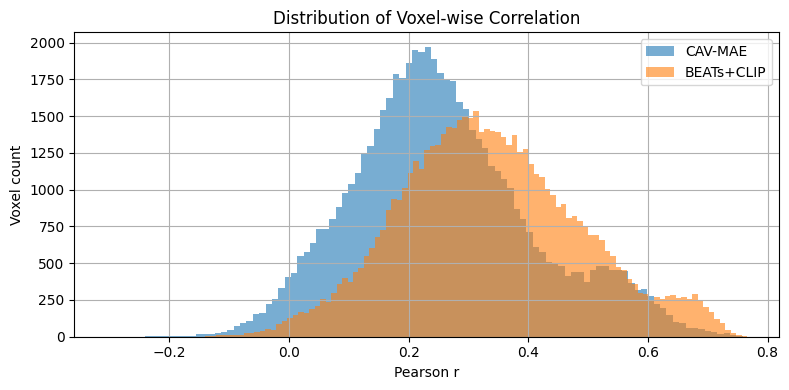

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(r_values_cavmae[~np.isnan(r_values_cavmae)], bins=100, alpha=0.6, label="CAV-MAE")
plt.hist(r_values_beats_clip[~np.isnan(r_values_beats_clip)], bins=100, alpha=0.6, label="BEATs+CLIP")
plt.xlabel("Pearson r")
plt.ylabel("Voxel count")
plt.title("Distribution of Voxel-wise Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



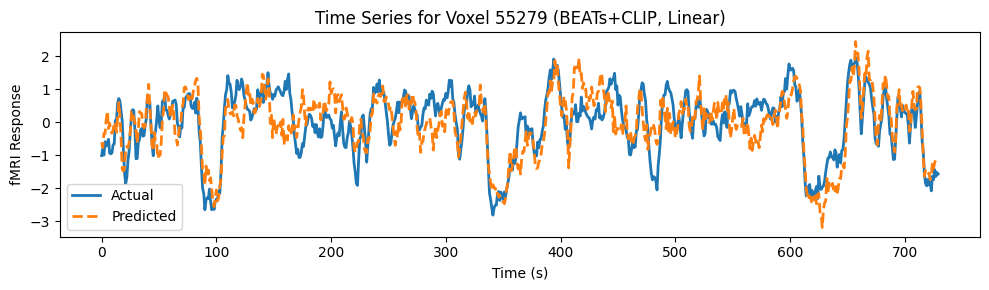

In [12]:
best_voxel = np.nanargmax(r_values_beats_clip)

plt.figure(figsize=(10, 3))
plt.plot(Y_test[:, best_voxel], label="Actual", linewidth=2)
plt.plot(Y_pred2_linear[:, best_voxel], label="Predicted", linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("fMRI Response")
plt.title(f"Time Series for Voxel {best_voxel} (BEATs+CLIP, Linear)")
plt.legend()
plt.tight_layout()
plt.show()


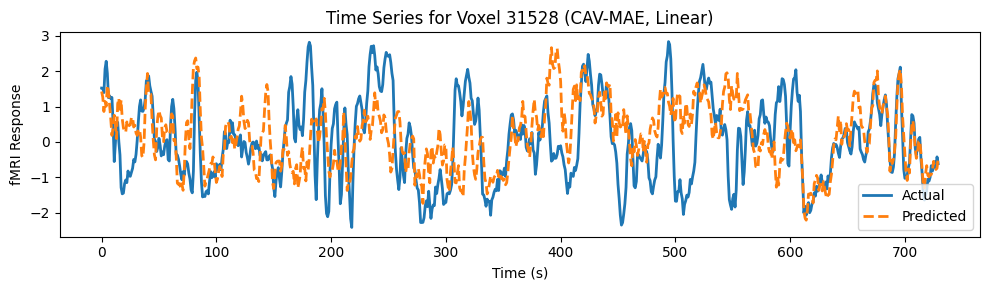

In [13]:
best_voxel = np.nanargmax(r_values_cavmae)

plt.figure(figsize=(10, 3))
plt.plot(Y_test[:, best_voxel], label="Actual", linewidth=2)
plt.plot(Y_pred2_linear[:, best_voxel], label="Predicted", linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("fMRI Response")
plt.title(f"Time Series for Voxel {best_voxel} (CAV-MAE, Linear)")
plt.legend()
plt.tight_layout()
plt.show()


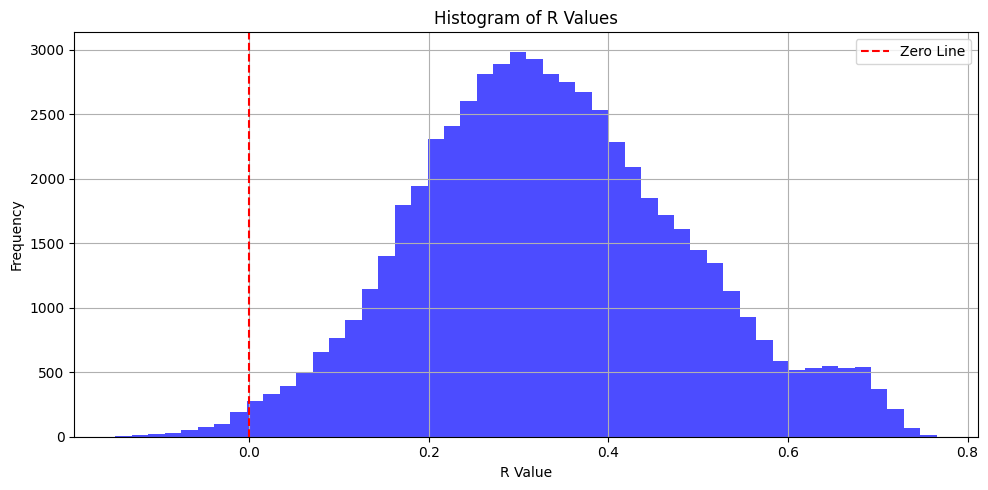

In [14]:
import numpy as np
import matplotlib.pyplot as plt

r_values = r_values_beats_clip

# Remove NaNs
valid_r = r_values[~np.isnan(r_values)]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(valid_r, bins=50, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.title("Histogram of R Values")
plt.xlabel("R Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


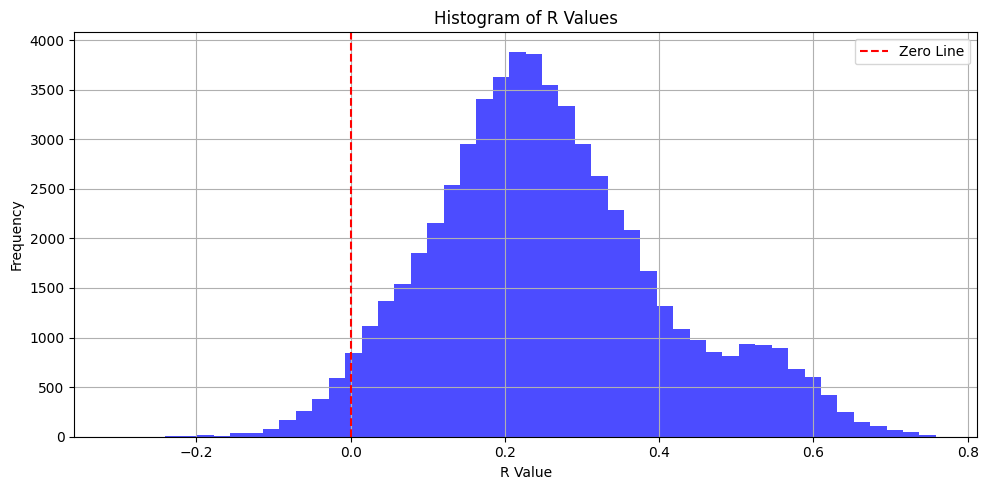

In [15]:
import numpy as np
import matplotlib.pyplot as plt

r_values = r_values_cavmae

# Remove NaNs
valid_r = r_values[~np.isnan(r_values)]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(valid_r, bins=50, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.title("Histogram of R Values")
plt.xlabel("R Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

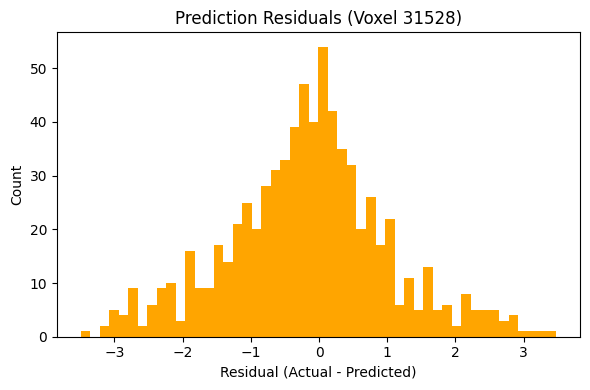

In [16]:
residuals = Y_test[:, best_voxel] - Y_pred2_linear[:, best_voxel]

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, color='orange')
plt.title(f"Prediction Residuals (Voxel {best_voxel})")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



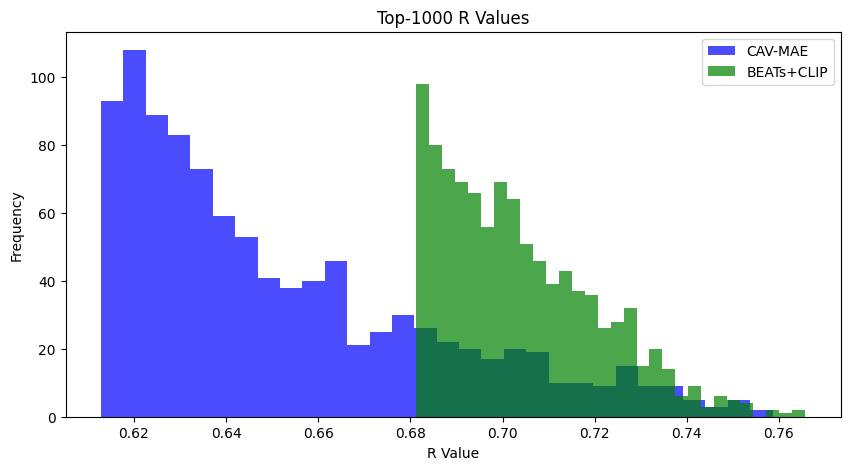

In [17]:
#top k r values
import matplotlib.pyplot as plt

k = 1000
topk_cavmae = np.sort(r_values_cavmae[~np.isnan(r_values_cavmae)])[-k:]
topk_beatsclip = np.sort(r_values_beats_clip[~np.isnan(r_values_beats_clip)])[-k:]
plt.figure(figsize=(10, 5))
plt.hist(topk_cavmae, bins=30, alpha=0.7, color='blue', label='CAV-MAE')
plt.hist(topk_beatsclip, bins=30, alpha=0.7, color='green', label='BEATs+CLIP')
#plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.title(f'Top-{k} R Values')
plt.xlabel('R Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [18]:
#mean r values for cav mae
r_LH_cavmae = r_values_cavmae[:32492]
r_RH_cavmae = r_values_cavmae[32492:]
r_RH_cavmae = r_RH_cavmae[~np.isnan(r_RH_cavmae)]
r_LH_cavmae = r_LH_cavmae[~np.isnan(r_LH_cavmae)]
avg_r_RH_cavmae = np.mean(r_RH_cavmae)
avg_r_LH_cavmae = np.mean(r_LH_cavmae)
#mean r values for beats clip
r_LH_beats_clip = r_values_beats_clip[:32492]
r_RH_beats_clip = r_values_beats_clip[32492:]
r_RH_beats_clip = r_RH_beats_clip[~np.isnan(r_RH_beats_clip)]
r_LH_beats_clip = r_LH_beats_clip[~np.isnan(r_LH_beats_clip)]
avg_r_RH_beats_clip = np.mean(r_RH_beats_clip)
avg_r_LH_beats_clip = np.mean(r_LH_beats_clip)

avg_cavmae = [avg_r_LH_cavmae, avg_r_RH_cavmae]
avg_beats_clip = [avg_r_LH_beats_clip, avg_r_RH_beats_clip]
#avg r value in each region
print(f"CAV-MAE LH: {avg_r_LH_cavmae:.3f}")
print(f"CAV-MAE RH: {avg_r_RH_cavmae:.3f}")
print(f"BEATs+CLIP LH: {avg_r_LH_beats_clip:.3f}")
print(f"BEATs+CLIP RH: {avg_r_RH_beats_clip:.3f}")


CAV-MAE LH: 0.258
CAV-MAE RH: 0.258
BEATs+CLIP LH: 0.327
BEATs+CLIP RH: 0.347


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

def mod(X_win, Y_win, model_name, alpha=1.0, epochs=50, batch_size=1024, lr=1e-3):
    n_samples = X_win.shape[0]
    split_idx = int(0.8*n_samples) #80 trianing 20 test
    X_trainf, X_testf = X_win[:split_idx], X_win[split_idx:]
    Y_trainf, Y_testf = Y_win[:split_idx], Y_win[split_idx:]

    X_train = torch.tensor(X_trainf, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_trainf, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_testf, dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y_testf, dtype=torch.float32).to(device)
    dataset = TensorDataset(X_train, Y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = nn.Linear(X_train.shape[1], Y_train.shape[1], bias=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x1, y1 in loader:
            optimizer.zero_grad()
            pred = model(x1)
            loss = F.mse_loss(pred, y1)+alpha*torch.sum(model.weight**2)  #mse loss + l2 penalty term alpha*sum(w^2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_test).cpu().numpy()
        Y_true = Y_test.cpu().numpy()

    #get pearson corr
    r_values = np.full(Y_true.shape[1], np.nan)#some voxels are empty -> np.nan ignore them
    for i in range(Y_true.shape[1]):
        y_true = Y_true[:, i]
        y_pred = Y_pred[:, i]
        if np.std(y_true) < 1e-8 or np.std(y_pred) < 1e-8:
            continue
        r_values[i], _ = pearsonr(y_true, y_pred)

    valid = ~np.isnan(r_values)
    mean_r = np.nanmean(r_values)
    print(f"[{model_name}] Mean r: {mean_r:.3f}")
    return r_values


cuda


In [20]:

X_win_audio, Y_win = create_windowed_data(X_audio, Y_full, window_length)#get beats audio featuers (time steps, dimensions per time)
X_win_visual, _ = create_windowed_data(X_visual, Y_full, window_length) #get clip visual features
X_win_beats_clip, _ = create_windowed_data(X_av_concat, Y_full, window_length)#get beats+clip audio-visual features
X_win_cavmae, _ = create_windowed_data(X_av, Y_full, window_length)#get cav-mae audio-visual features

left_vox = Y_win[:, :32492] #1st 32k voxels left hemisphere -> Y_win (num windows, num voxels)
right_vox = Y_win[:, 32492:] #last 32k voxels right hemisphere
Y_win_subset = np.concatenate([left_vox[:, :5000], right_vox[:, :5000]], axis=1)#only do 10k voxel cuda run out of mem otherwise
rvalues_audio = mod(X_win_audio, Y_win_subset, "Audio only (BEATs)", batch_size=256)
torch.cuda.empty_cache()
import gc; gc.collect()
rvalues_visual = mod(X_win_visual, Y_win_subset, "Visual only (CLIP)", batch_size=256)
torch.cuda.empty_cache()
gc.collect()
rvalues_beats_clip = mod(X_win_beats_clip, Y_win_subset, "Multimodal (BEATs+CLIP)", batch_size=128)
torch.cuda.empty_cache()
gc.collect()
rvalues_cavmae = mod(X_win_cavmae, Y_win_subset, "Multimodal (CAV-MAE)", batch_size=128)
torch.cuda.empty_cache()
gc.collect()

mean_r_audio = np.nanmean(rvalues_audio)#ignore empty voxels
mean_r_visual = np.nanmean(rvalues_visual)
mean_r_beats_clip = np.nanmean(rvalues_beats_clip)
mean_r_cavmae = np.nanmean(rvalues_cavmae)

print(f"Audio only - BEATs:         Mean r = {mean_r_audio:.3f}")
print(f"Visual only - CLIP:         Mean r = {mean_r_visual:.3f}")
print(f"Multimodal - BEATs + CLIP:  Mean r = {mean_r_beats_clip:.3f}")
print(f"Multimodal - CAV-MAE:       Mean r = {mean_r_cavmae:.3f}")


[Audio only (BEATs)] Mean r: -0.036
[Visual only (CLIP)] Mean r: 0.375
[Multimodal (BEATs+CLIP)] Mean r: 0.297
[Multimodal (CAV-MAE)] Mean r: 0.356
Audio only - BEATs:         Mean r = -0.036
Visual only - CLIP:         Mean r = 0.375
Multimodal - BEATs + CLIP:  Mean r = 0.297
Multimodal - CAV-MAE:       Mean r = 0.356
